# Important Notes:
## Notebook Text Cells
This Notebook relies on the open-source architecture of cycle-gan published in this [article](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/). As it was developed for incorporating understanding and implementation, you may find text cells that explain the architecture where you would find the word "**EXPLAIN**" before it. 

## Dataset:
The dataset used here is a sample of texture data available [here](https://www.cb.uu.se/~gustaf/texture/)

## New Implementation:
The parts we believe might be new in this specific problem and method are highlighted by "**NEW Trial**" to facilitate tracking



# 0. Import Libraries

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot
from keras import layers
import tensorflow as tf
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We have 2 generators and 2 discriminators corresponding to each domain of images (could be the real images and the stegano one; re-check the paper to know what are your 2 domains of images)

# Explain 1.\
Domain-A -> Discriminator-A -> [Real/Fake] \
Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]

Domain-B -> Discriminator-B -> [Real/Fake]\
Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

# Explain 2.\
Cycle Consistency \
((Genertor A: means it generate sth as domain A, but takes input as anything except domain A)) \
**Domain-B** -> **Generator-A** -> **Domain-A** -> Generator-B -> Domain-B
# Explain 3.\
Identity Mapping (result in better color profile)

## The next code until (4) if ran once, no need for running it again and we use the compressed file directly

# 1. Load the images of Domain A (Texture) [train+test] into two arrays

In [ ]:
# example of preparing the horses and zebra dataset
from os import listdir
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed
import pandas as pd
from PIL import Image, ImageDraw
import random as rd
import numpy as np

#### 1.1. Unzip the data

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/final.zip","r") as zip_ref:
    zip_ref.extractall("final")

#### 1.2. Load the data in numpy arrays

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

# dataset path
path = '/content/final/final/'

# load dataset A
dataA1 = load_images(path + 'trainA/')
dataAB = load_images(path + 'testA/')
dataA = vstack((dataA1, dataAB))
print('Loaded dataA: ', dataA.shape)


Loaded dataA:  (299, 256, 256, 3)


# 2. Domain B (Text) [train+test]
# Load the CSV file and generate blank images with the text
# **NEW Trial**

#### 2.1. Load the csv file

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/tamil_thirukkural_train.csv")
sub_df= dataset.iloc[0]

#### 2.2. Generate train images from the text (text colored in yellow) and the background changes each time

In [ ]:
text_img =[]
Rand_number_for_color = randint(0, 255)
for i in range(0,239):
  img = Image.new('RGB', (256, 256), color = (Rand_number_for_color, Rand_number_for_color, Rand_number_for_color))
  d = ImageDraw.Draw(img)
  d.text((5,5), dataset.at[i,'explanation'], fill=(255,255,0))
  n = np.array(img)
  text_img.append(n)

#### 2.3. Generate train images from the text

In [ ]:
text_img_test =[]
for i in range(239,299):
  img = Image.new('RGB', (256, 256), color = (Rand_number_for_color, Rand_number_for_color, Rand_number_for_color))
  d = ImageDraw.Draw(img)
  d.text((5,5), dataset.at[i,'explanation'], fill=(255,255,0))
  n = np.array(img)
  text_img_test.append(n)


#### 2.4. Convert to NumPy arrays

In [ ]:
list_of_gen_img_train = np.array(text_img)
list_of_gen_img_test = np.array(text_img_test)

# 3. Compressing the images of the two domains together

In [ ]:
dataA = vstack((dataA1, dataAB))
dataB = vstack((list_of_gen_img_train, list_of_gen_img_test))

In [ ]:
filename = '/content/drive/MyDrive/CS_text.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/MyDrive/CS_text.npz


## 3.2. Load the compressed images and plot, for exploration

Loaded:  (299, 256, 256, 3) (299, 256, 256, 3)


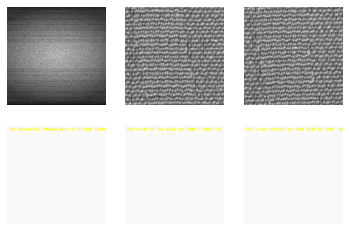

In [ ]:
# load and plot the prepared dataset
from numpy import load
from matplotlib import pyplot

# load the dataset
data = load('/content/drive/MyDrive/CS_text.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)

# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
 
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

# 4. Develop Cycle GAN
(Use keras; output -> Color Images of size 256x256) \
- The architecture is comprised of **four** models, **two discriminator** models, and **two generator** models.



## 4.1. Discriminator Model
## Explain

- **Discriminator** is CNN for **image classification**; one for each domain.

- CycleGAN **discriminator**: `Convolutional-BatchNorm-LeakyReLU` but uses **InstanceNormalization** instead of BatchNormalization; standardizing the values on **each output feature map**, rather than across features in a batch. Instance norm has implementation in [keras contrib project](https://github.com/keras-team/keras-contrib).

- The discriminator model takes a 256×256 sized image as input and **outputs** a **patch of predictions 70x70**

In [ ]:
# define the discriminator model
def define_discriminator(image_shape):

	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  # “axis” argument is set to -1 to ensure that features are normalized per feature map.
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
 
	return model

## 4.2. Generator Model
## Explain
- Generator is an **encoder-decoder** model.
- Model takes **source image** (domain A) and generates **target image** (domain B).
1. Downsample (encode) input (by bottleNeck)
2. Interpret this by **ResNet**, then series of **upsample** or decode to return back to original size.


### 4.2.1. ResNet Original
##### ResNet: Used to solve the problem of the DL models having exploding or vanishing gradients.

In [ ]:
# Generator: ResNet block
def resnet_block_original(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first layer convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

### 4.2.2. ResNet Modified (as in [GAN-CLS](https://arxiv.org/abs/1806.11302))
# **NEW Trial**

In [ ]:
# Generator: ResNet block
#### Probably we can ignore this
def resnet_block_modified(n_filters, input_layer): ### we may change the n_filters to 256 instead of 64
	# weight initialization
  
  init = RandomNormal(stddev=0.02)
  g = Conv2D(64, (3,3) , strides = 1, padding='same', kernel_initializer=init)(input_layer)
  g = layers.BatchNormalization(momentum=0.5)(g)
  g = tf.keras.layers.PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(g)
  g = Conv2D(64, (3,3), strides = 1, padding='same', kernel_initializer=init)(g)
  g = layers.BatchNormalization(momentum=0.5)(g)
  g = Concatenate()([g, input_layer])
  return g

### 4.2.3. Generator

In [ ]:
### 9-ResNet blocks for 256x256 images for generator

# define the standalone generator model
def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block_modified(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

## 4.3. Composite Model

## Explain
- **Discriminator** models are trained directly on **real and generated** images.
- Generator models are trained via their discriminator models to **minimize** the **adversarial loss** [For discriminator decibt]. (**L2 distance** between model out and target values '1: real', '0: fake')
- Also, generators have "**cycle loss**" [For regeneration]. (2 losses: Fwd + Bwd)
- Finally, **Identity loss** [Maintain same image if it's originally from the target domain] (1 Loss)

== Both **cycle and Identity loss** are **L1 distance ** between input and output image for each translation \
== A composite model is built to allow sharing the weights of the generator with the related discriminator. \
- The composite model has 2 inputs (images from A and B) and 4 outputs (discriminator out, identity generated image, forward-cycle generated img, bwd cycle img)




In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

We need to create a composite model for each generator: Generator-A (input: B, out: A) and Generator B. \
- Here: A -> Horse \

**Generator-A Composite Model** (BtoA or Zebra to Horse)

The inputs, transformations, and outputs of the model are as follows:

**Adversarial Loss**: Domain-B -> Generator-A -> Domain-A -> Discriminator-A -> [real/fake]
**Identity Loss**: Domain-A -> Generator-A -> Domain-A
**Forward Cycle Loss**: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
**Backward Cycle Loss**: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A
We can summarize the inputs and outputs as:

Inputs: Domain-B, Domain-A
Outputs: Real/Fake, Domain-A, Domain-B, Domain-A


# 5. Functions for Images shuffling and reconstruction
### 5.1. Load images as a list of 2 numpy array (coming from the compressed NPZ) [1st source image, 2nd target image]

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

### 5.2. Selecting Random batches of images from each domain for the discriminator and composite generator

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

### 5.3. Select Sample of generated images to update the discriminator

In [ ]:
# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

Note that GANs don't converge rather they reach an **equilibrium** state, thus we can decide when to **stop** (epochs) based on the **generated image quality** (save generator each n epochs and generate with it)

# 6. Model performance
### 6.1. Save generator models each epoch

In [ ]:
# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

### 6.2. For tracking: Plot Sample of source images (1st row) against the generated images (2nd row)

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

#### Note: Image Pool for discriminator

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

# 7. Train Models
The batch size is 1, so the number of iterations in each epoch. Models are saved every 5 epochs.

Images are generated using both generators each epoch.

Batch of real images from each domain is selected then a batch of fake images is generated to update each discriminator's fake image pool.

Generator-A is updated by the composite model then by discriminator-A.

In [ ]:
# train cyclegan models
### 2 generator, 2 discriminator, 2 composite
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
	# define properties of the training run
  #### epochs: changed to 10 to fasten the work a bit
	n_epochs, n_batch, = 20, 1
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/MyDrive/CS_text.npz')

print('Loaded', dataset[0].shape, dataset[1].shape)

# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)

# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)

# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)



Loaded (299, 256, 256, 3) (299, 256, 256, 3)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1, dA[1.214,0.731] dB[0.673,0.830] g[20.483,19.949]
>2, dA[0.839,4.455] dB[8.570,0.703] g[20.698,25.814]
>3, dA[1.611,13.302] dB[4.394,0.605] g[20.204,35.249]
>4, dA[0.728,8.867] dB[4.575,0.530] g[21.567,26.208]
>5, dA[0.999,8.410] dB[1.606,0.556] g[20.207,24.499]
>6, dA[0.606,4.926] dB[0.924,0.578] g[20.033,20.408]
>7, dA[0.858,2.894] dB[0.687,0.525] g[19.588,18.960]
>8, dA[0.649,1.723] dB[0.296,0.514] g[19.316,18.092]
>9, dA[2.140,0.329] dB[0.123,0.484] g[18.739,16.857]
>10, dA[0.570,0.434] dB[0.105,0.474] g[18.826,17.278]
>11, dA[0.541,0.956] dB[0.137,0.531] g[17.997,16.183]
>12, dA[0.567,1.294] dB[0.142,0.708] g[19.362,17.683]
>13, dA[6.960,0.596] dB[0.201,1.597] g[18.956,15.101]
>14, dA[0.665,0.072] dB[0.132,1.057] g[19.214,14.738]
>15, dA[0.506,0.035] dB[0.110,0.701] g[19.982,18.282]
>16, dA[0.573,0.029] dB[0.052,0.660] g[17.763,14.375]
>17, dA[0.491,0.021] dB[0.058,0.614] g[17.442,13.993]
>18, dA[0.548,0.019] dB[0.069,0.529] g[17.196,13.916]
>19, dA[0.094,0.014] dB[0.068,7.077]

KeyboardInterrupt: ignored

**Trials**
For small Data (37, 38 train images):
1. For 5 epochs and  => no change in the images just a little bluring.
2. For 100 epochs and same number of images => Same as the previous (we need large number of dataset)

===> As this didn't work, we must provide some sort of large dataset.

# 8. Image Translation with Cycle-GAN (Reconstruction Example)

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X

In [ ]:
# plot the image, the translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		pyplot.subplot(1, len(images), 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
		# title
		pyplot.title(titles[i])
	pyplot.show()

In [ ]:
# load dataset
A_data, B_data = load_real_samples('/content/drive/MyDrive/CS_text.npz')
print('Loaded', A_data.shape, B_data.shape)

Loaded (299, 256, 256, 3) (299, 256, 256, 3)


In [ ]:
#### Specify how to load the InstanceNormalization layer while loading the genenrator model
# load the models
## Take the generators at epoch 7
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/g_model_AtoB_001495.h5', cust)
model_BtoA = load_model('/content/g_model_BtoA_001495.h5', cust)

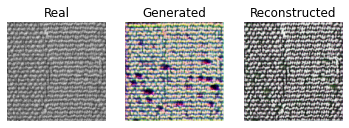

In [ ]:
## Select image from Domain-A, convert it to B by generator AtoB
## then reconstruct it to A again by Generator BtoA

# plot A->B->A
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

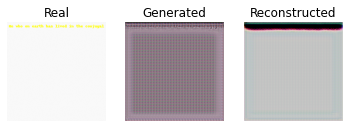

In [ ]:
# plot B->A->B
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)


# 9. Beneficial Extensions (General)

- Smaller Image Size. Update the example to use a smaller image size, such as 128×128
- Adjust the size of the generator model to use 6 ResNet layers as is used in the cycleGAN paper.
- Without Identity Mapping. Update the example to train the generator models without the identity mapping and compare results.
- Try with mini-batch; instead of batch = 1, make it 16

And more sophisticated ones discussed in the presentation